# Predicting Road Accident Risk
### Notebook 1: Data Preprocessing Pipeline

**Proje Ekibi:**
* **Esmanur Ulu** - 231101024
* **Nehir Tıraş** - 231101065
* **Zeynep Yetkin** - 231101042

---


**Amaç:**
Bu notebook, projenin temelini oluşturan **Veri Ön İşleme (Data Preprocessing)** hattını inşa etmek için hazırlanmıştır. Kaggle Playground Series'den elde edilen 570K+ satırlık sentetik veri seti; eksik veri analizi, öznitelik mühendisliği (feature engineering) ve ölçeklendirme işlemlerinden geçirilerek model eğitimine hazır hale getirilecektir.

**Süreç Adımları:**
1.  **Veri Yükleme & Temizlik:** Gereksiz sütunların (id) atılması ve veri bütünlüğünün kontrolü.
2.  **Keşifçi Veri Analizi (Unsupervised):** Veri setinin geometrisini anlamak için K-Means ve PCA analizleri.
3.  **Train-Validation Ayrımı:** Veri sızıntısını (Data Leakage) önlemek için doğru ayırma stratejisi.
4.  **Pipeline Kurulumu:** Kategorik ve sayısal verilerin `ColumnTransformer` ile işlenmesi.
5.  **Dışa Aktarım:** İşlenmiş verilerin `.csv` olarak kaydedilmesi.

## 1. Ortam Kurulumu ve Klasör Yapısı
Proje dosyalarının düzenli tutulması ve ekip içi senkronizasyonun sağlanması amacıyla Google Drive üzerinde standart bir klasör hiyerarşisi oluşturulmaktadır.
* `data/`: Ham ve işlenmiş veriler.
* `models/`: Eğitilen model dosyaları (.pkl, .pth).
* `notebooks/`: Analiz kodları.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

base_path = "/content/drive/MyDrive/YAP470_Proje"
folders = ["data", "processed", "models", "results", "notebooks"]

for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

print("Klasör yapısı başarıyla oluşturuldu.")


Klasör yapısı başarıyla oluşturuldu.


## 2. Veri Setinin Yüklenmesi ve İlk Temizlik
Veri setindeki `id` sütunu, her bir kaydı benzersiz kılan bir tanımlayıcıdır ancak kaza riski (`accident_risk`) üzerinde analitik bir değeri yoktur. Modelin bu rastgele sayıları ezberlemesini (overfitting) engellemek için eğitim setinden çıkarılacaktır.

Ancak, Kaggle submission aşamasında tahminleri eşleştirmek için **Test setindeki ID'ler** ayrı bir değişkende saklanacaktır.

In [ ]:
import pandas as pd

train_path = f"{base_path}/data/train.csv"
test_path  = f"{base_path}/data/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Train ve Test verileri başarıyla yüklendi.")
train.head()


Train ve Test verileri başarıyla yüklendi.


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [ ]:
# ID'yi ayrıştırma
test_ids = test["id"].copy()

# ID sütununu kaldır
train = train.drop(columns=["id"])
test  = test.drop(columns=["id"])

print("ID sütunları analizden çıkartıldı.")


ID sütunları analizden çıkartıldı.


In [ ]:
missing_train = train.isnull().sum()
missing_test  = test.isnull().sum()

print("Train Missing Values:\n", missing_train)
print("\nTest Missing Values:\n", missing_test)


Train Missing Values:
 road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

Test Missing Values:
 road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=["accident_risk"])
y = train["accident_risk"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train seti boyutu:", X_train.shape)
print("Validation seti boyutu:", X_val.shape)

Train seti boyutu: (414203, 12)
Validation seti boyutu: (103551, 12)


In [ ]:
import pandas as pd
import numpy as np


categorical_cols = [c for c in ["road_type", "lighting", "weather", "time_of_day"] if c in cols]
numeric_cols     = [c for c in ["speed_limit", "num_lanes", "curvature", "num_reported_accidents"] if c in cols]
boolean_cols     = [c for c in ["road_signs_present", "public_road", "holiday", "school_season"] if c in cols]

max_len = max(len(categorical_cols), len(numeric_cols), len(boolean_cols))


cat_padded  = categorical_cols + ['-'] * (max_len - len(categorical_cols))
num_padded  = numeric_cols     + ['-'] * (max_len - len(numeric_cols))
bool_padded = boolean_cols     + ['-'] * (max_len - len(boolean_cols))


df_features = pd.DataFrame({
    "Kategorik (Nominal)": cat_padded,
    "Sayısal (Numeric)": num_padded,
    "Boolean (Binary)": bool_padded
})


print(f"Toplam Özellik Sayısı: {len(cols)}")
display(df_features)

Toplam Özellik Sayısı: 12


,Kategorik (Nominal),Sayısal (Numeric),Boolean (Binary)
0,road_type,speed_limit,road_signs_present
1,lighting,num_lanes,public_road
2,weather,curvature,holiday
3,time_of_day,num_reported_accidents,school_season


## 3. Veri Yapısını Anlama: PCA Analizi (Unsupervised Analysis)

Model eğitimine geçmeden önce, elimizdeki çok boyutlu (12+ öznitelik) veri setini insan gözüyle algılanabilir hale getirmek ve verinin genel geometrisini anlamak istiyoruz. Bu amaçla **PCA (Principal Component Analysis - Temel Bileşen Analizi)** yöntemi kullanılacaktır.

**Analizin Hedefi:**
* **Boyut İndirgeme:** Farklı ölçeklerdeki (hız limiti, şerit sayısı vb.) ve türdeki (hava durumu, yol tipi) değişkenleri, bilgi kaybını en aza indirerek 2 boyutlu bir düzleme (X ve Y ekseni) izdüşürmek.
* **Görselleştirme:** Veri noktalarının uzaydaki dağılımına bakarak; verinin rastgele mi dağıldığını yoksa belirli örüntüler (pattern) mi içerdiğini görmek.
* **Hipotez:** Oluşturacağımız 2 boyutlu haritada, `accident_risk` değerleri (renkler) belirgin bir geçiş veya gruplaşma gösteriyor mu?
    * *Eğer renkler düzenli bir geçiş gösteriyorsa:* Modelin öğrenmesi kolay olacaktır.
    * *Eğer renkler karmaşık ve iç içe geçmişse:* Basit lineer modeller yetersiz kalacak, **Derin Öğrenme (Deep Learning)** kullanımı zorunlu hale gelecektir.

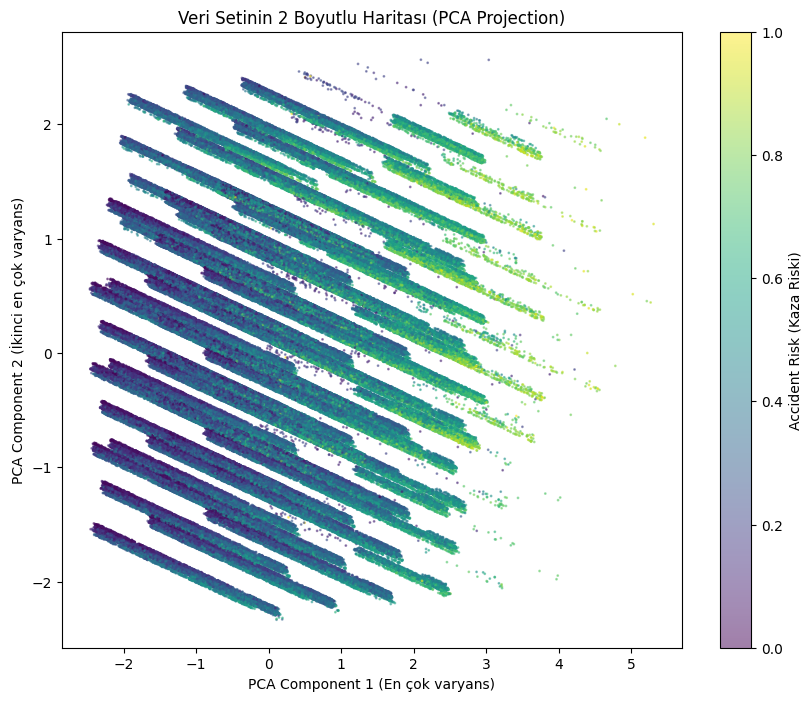

Bu iki boyut, toplam verinin %28.18'sini açıklıyor.


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


X = train.drop(columns=["accident_risk"])
y = train["accident_risk"]

cols = X.columns.tolist()


categorical_cols = [c for c in ["road_type", "lighting", "weather", "time_of_day"] if c in cols]
numeric_cols     = [c for c in ["speed_limit", "num_lanes", "curvature", "num_reported_accidents"] if c in cols]
boolean_cols     = [c for c in ["road_signs_present", "public_road", "holiday", "school_season"] if c in cols]


pca_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
        ("bool", "passthrough", boolean_cols)
    ],
    verbose_feature_names_out=False
)


X_pca_ready = pca_preprocessor.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca_ready)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="viridis", alpha=0.5, s=1)
plt.xlabel("PCA Component 1 (En çok varyans)")
plt.ylabel("PCA Component 2 (İkinci en çok varyans)")
plt.title("Veri Setinin 2 Boyutlu Haritası (PCA Projection)")
plt.colorbar(scatter, label="Accident Risk (Kaza Riski)")
plt.show()

print(f"Bu iki boyut, toplam verinin %{sum(pca.explained_variance_ratio_)*100:.2f}'sini açıklıyor.")

### PCA Grafiğinin Yorumlanması: Yapısal Ayrışma

Elde edilen 2 boyutlu PCA izdüşümü incelendiğinde, verilerin rastgele bir bulut oluşturmak yerine **belirgin, paralel şeritler (bands)** halinde kümelendiği görülmektedir.

**Bu yapının nedenleri ve analitik sonuçları şunlardır:**

1.  **Ayrık (Discrete) Yapı:** Görülen şeritli yapı, veri setindeki yoğun kategorik değişkenlerin (Yol tipi, Hava durumu vb.) **One-Hot Encoding** işlemi sonrası uzayda oluşturduğu doğal matematiksel düzlemlerdir.
2.  **Risk Dağılımı (Renk Kodları):**
    * Grafiğin sol/alt kısımlarının ağırlıklı olarak **Mor (Düşük Risk)**,
    * Sağ/üst kısımların ve şerit uçlarının ise **Sarı/Yeşil (Yüksek Risk)** tonlarında olduğu görülmektedir.
3.  **Model Seçimine Etkisi:** Verinin bu "parçalı" ve "doğrusal olmayan" (non-linear) geometrisi, basit lineer modellerin (Ridge/Lasso) neden yetersiz kalabileceğini görsel olarak kanıtlamaktadır. Bu ayrık bölgeler arasındaki karmaşık ilişkileri yakalayabilmek için **Multi-Layer Perceptron (Derin Öğrenme)** gibi yüksek kapasiteli modellerin kullanımı gereklidir.

## 3.2. Örüntü Keşfi: K-Means Kümeleme Analizi (Unsupervised Learning)

PCA analizi ile verinin boyutunu indirgeyip görselleştirdikten sonraki adım, bu veri uzayında **matematiksel olarak benzer** grupların (kümelerin) oluşup oluşmadığını incelemektir. Bu amaçla, *gözetimsiz öğrenme (unsupervised learning)* algoritmalarından **K-Means** kullanılacaktır.

**Analizin Temel Amaçları:**

1.  **Doğal Gruplaşmaların Tespiti:** Veri seti içerisinde insan gözüyle görülemeyen, ancak özniteliklerin (hız, şerit sayısı, hava durumu vb.) kombinasyonuyla oluşan **gizli alt yapılar (latent structures)** var mı?
2.  **Risk ile İlişki:** Algoritmanın bulduğu bu kümeler, hedef değişkenimiz olan `accident_risk` ile örtüşüyor mu?
    * *Beklenti:* Örneğin; "Küme 1" ağırlıklı olarak düşük riskli, "Küme 2" ise yüksek riskli verileri içeriyorsa, bu durum verinin ayırt edilebilir (learnable) olduğunu kanıtlar.
3.  **Model Mimarisine Işık Tutma:** Eğer kümeler ve risk değerleri arasında **lineer olmayan (karmaşık)** bir ilişki varsa; projemizin ana yöntemi olan **Derin Öğrenme (MLP)** yaklaşımının gerekliliği bir kez daha doğrulanmış olacaktır.

**Yöntem:**
* **Girdi:** Önceki adımda PCA için hazırlanan ve ölçeklenmiş veri (`X_pca_ready`).
* **Parametre:** Başlangıç olarak `k=3` (veya `k=5`) küme sayısı seçilerek model eğitilir.
* **Görselleştirme:** Elde edilen küme etiketleri (labels), PCA'nın 2 boyutlu düzlemi üzerine boyanarak yorumlanır.

> **Önemli Not:** Veri setimiz yoğun miktarda *One-Hot Encoded* (0 ve 1'lerden oluşan) kategorik değişken içerdiği için, K-Means algoritması kümeleri oluştururken genellikle bu kategorik ayrımları (örn: Yol Tipleri) baz alacaktır. Bu durum, PCA grafiğinde gördüğümüz "şeritli" yapıyla birebir örtüşen bir kümeleme sonucu doğurabilir.

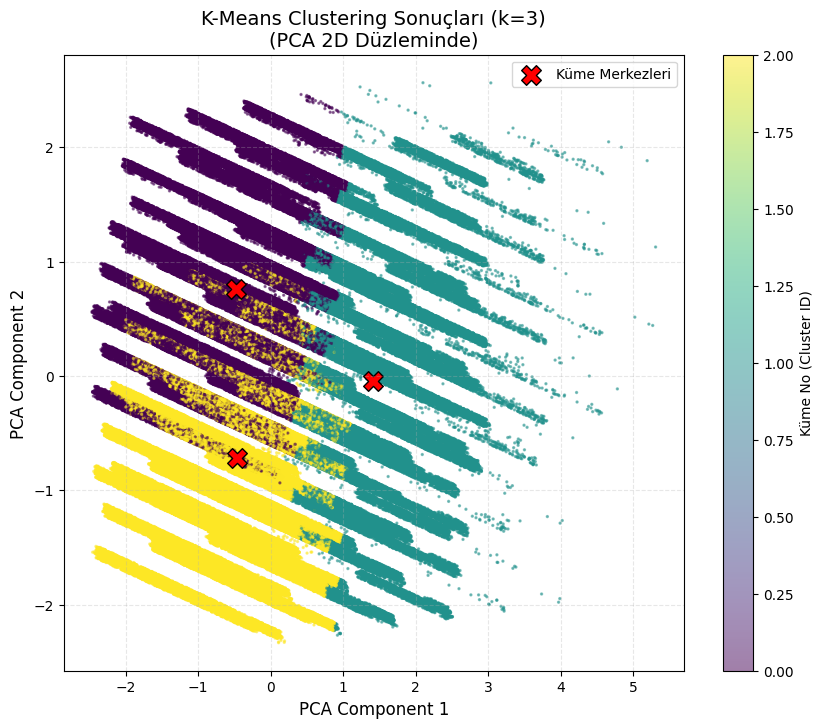

Kümeleme Tamamlandı. Her kümedeki eleman sayısı:
Küme 0: 191780 veri noktası
Küme 1: 130227 veri noktası
Küme 2: 195747 veri noktası


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_ready)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=clusters, cmap='viridis',
                      s=2, alpha=0.5)

centers_pca = []
for i in range(k):
    center = X_pca[clusters == i].mean(axis=0)
    centers_pca.append(center)
centers_pca = np.array(centers_pca)

plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            c='red', s=200, marker='X', label='Küme Merkezleri', edgecolors='black')


plt.title(f"K-Means Clustering Sonuçları (k={k})\n(PCA 2D Düzleminde)", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.colorbar(scatter, label="Küme No (Cluster ID)")
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


print("Kümeleme Tamamlandı. Her kümedeki eleman sayısı:")
unique, counts = np.unique(clusters, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Küme {u}: {c} veri noktası")

### K-Means Kümeleme Analizi Sonuçları

Yukarıdaki grafik incelendiğinde, K-Means algoritmasının (k=3) veri setini PCA düzlemi üzerinde üç belirgin bölgeye ayırdığı görülmektedir.

**Görsel Çıkarımlar:**
1.  **Bölgesel Ayrışma:** Kümeler (Renkler), PCA eksenleri üzerinde belirgin sınırlar oluşturmuştur. Bu sınırlar, veri setindeki yapısal farklılıkları (Örn: Yol tipi veya Hız limiti grupları) temsil eder.
2.  **Risk ile İlişki:** K-Means grafiğindeki **Yeşil Küme (Sağ taraf)**, bir önceki PCA grafiğinde **Yüksek Risk (Sarı)** olarak görülen bölgeyle büyük oranda örtüşmektedir.
3.  **Sonuç:** Bu durum, henüz hedef değişkeni (`accident_risk`) modele vermemiş olsak bile, verinin kendi içindeki özniteliklerin risk gruplarını ayırt etmede başarılı olduğunu göstermektedir. Yani veri seti, Derin Öğrenme modeli için oldukça elverişlidir.

In [ ]:
import pandas as pd


cluster_analysis = pd.DataFrame({
    "Cluster_Label": clusters,
    "Real_Accident_Risk": y
})

summary = cluster_analysis.groupby("Cluster_Label")["Real_Accident_Risk"].agg(["mean", "count", "std"])
summary = summary.sort_values(by="mean", ascending=False)

print("Kümelerin Risk İstatistikleri:")
display(summary)


high_risk_cluster = summary.index[0]
low_risk_cluster = summary.index[-1]
print(f"\nANALİZ SONUCU: \nAlgoritma, {high_risk_cluster} numaralı kümeyi 'Yüksek Riskli' grup olarak ayrıştırmayı başarmıştır.")
print(f"(Ortalama Risk: {summary.loc[high_risk_cluster, 'mean']:.4f})")

Kümelerin Risk İstatistikleri:


,mean,count,std
Cluster_Label,,,
1,0.470261,130227,0.156601
2,0.313296,195747,0.150842
0,0.312220,191780,0.149276



ANALİZ SONUCU: 
Algoritma, 1 numaralı kümeyi 'Yüksek Riskli' grup olarak ayrıştırmayı başarmıştır.
(Ortalama Risk: 0.4703)


## 4. Feature Engineering Pipeline (Öznitelik Mühendisliği Hattı)

Makine öğrenmesi modelleri, özellikle Derin Öğrenme (Deep Learning) mimarileri, ham metin veya farklı ölçekteki sayısal verilerle doğrudan çalışamaz. Bu bölümde, veri setindeki farklı tipteki değişkenleri matematiksel matrislere dönüştürmek için tek bir entegre **Pipeline** yapısı kurulmaktadır.

### Uygulanan Dönüşüm Stratejileri

Projede kullanılan `ColumnTransformer` yapısı, her veri tipine özel işlem uygular:

1.  **Kategorik Değişkenler (Nominal):**
    * **Yöntem:** `One-Hot Encoding`
    * **Amaç:** Kategoriler arasında matematiksel bir üstünlük (örn: Yağmurlu > Güneşli) olmadığı için, her kategori 0 ve 1'lerden oluşan ayrı sütunlara dönüştürülür.
    * **Güvenlik:** `handle_unknown='ignore'` parametresi ile test setinde eğitim setinde olmayan yeni bir kategori görülürse kodun hata vermesi engellenir.

2.  **Sayısal Değişkenler (Numeric):**
    * **Yöntem:** `StandardScaler` (Z-Score Normalization)
    * **Amaç:** Veriler ortalaması 0, standart sapması 1 olacak şekilde ölçeklenir. Bu işlem, Sinir Ağları (Neural Networks) ve PCA gibi varyansa duyarlı algoritmaların performansını artırmak için **zorunludur**.

3.  **Boolean Değişkenler:**
    * **Yöntem:** `passthrough`
    * **Amaç:** Veriler halihazırda 0/1 veya True/False formatında olduğu için herhangi bir dönüşüme tabi tutulmadan doğrudan modele iletilir.

---

### Kritik Önlem: Veri Sızıntısını Önleme (Data Leakage)

Modelin genelleme yeteneğini doğru ölçebilmek için:
* Dönüşüm kuralları (fit) **yalnızca X_train** veri seti üzerinden öğrenilir.
* Validation ve Test setleri, eğitim setinden öğrenilen bu kurallara göre sadece dönüştürülür (**transform**).

Bu yaklaşım, modelin gelecekteki (görmediği) verilerle ilgili istatistiksel bilgileri önceden "kopya çekmesini" engeller.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cols = X_train.columns.tolist()

categorical_cols = [c for c in ["road_type", "lighting", "weather", "time_of_day"] if c in cols]
numeric_cols = [c for c in ["speed_limit", "num_lanes", "curvature", "num_reported_accidents"] if c in cols]
boolean_cols = [c for c in ["road_signs_present", "public_road", "holiday", "school_season"] if c in cols]

print("Kategorik:", categorical_cols)
print("Sayısal:", numeric_cols)
print("Boolean:", boolean_cols)


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
        ("bool", "passthrough", boolean_cols)
    ],
    verbose_feature_names_out=False
)


X_train_processed = preprocessor.fit_transform(X_train)

print("Preprocessing pipeline fit edildi.")
print(f"İşlenmiş Veri Boyutu: {X_train_processed.shape}")

Kategorik: ['road_type', 'lighting', 'weather', 'time_of_day']
Sayısal: ['speed_limit', 'num_lanes', 'curvature', 'num_reported_accidents']
Boolean: ['road_signs_present', 'public_road', 'holiday', 'school_season']
Preprocessing pipeline fit edildi.
İşlenmiş Veri Boyutu: (414203, 20)


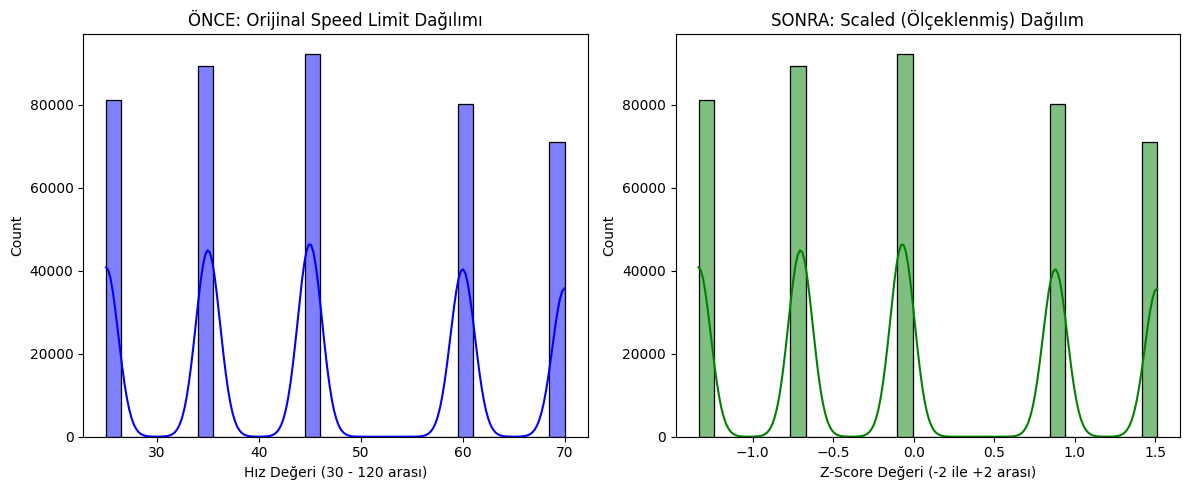

Orijinal Sütun Sayısı: 12
İşlenmiş (Processed) Sütun Sayısı: 20


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


feature_names = preprocessor.get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
sns.histplot(X_train['speed_limit'], kde=True, color='blue', bins=30)
plt.title("ÖNCE: Orijinal Speed Limit Dağılımı")
plt.xlabel("Hız Değeri (30 - 120 arası)")


plt.subplot(1, 2, 2)
col_name = [c for c in feature_names if 'speed_limit' in c][0]
sns.histplot(X_train_processed_df[col_name], kde=True, color='green', bins=30)
plt.title("SONRA: Scaled (Ölçeklenmiş) Dağılım")
plt.xlabel("Z-Score Değeri (-2 ile +2 arası)")

plt.tight_layout()
plt.show()

print(f"Orijinal Sütun Sayısı: {X_train.shape[1]}")
print(f"İşlenmiş (Processed) Sütun Sayısı: {X_train_processed.shape[1]}")

In [ ]:
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(test)

print("Validation ve Test setleri başarıyla dönüştürüldü.")
print("-" * 30)
print(f"X_train (İşlenmiş) Boyutu: {X_train_processed.shape}")
print(f"X_val   (İşlenmiş) Boyutu: {X_val_processed.shape}")
print(f"X_test  (İşlenmiş) Boyutu: {X_test_processed.shape}")
print("-" * 30)


if X_train_processed.shape[1] == X_val_processed.shape[1] == X_test_processed.shape[1]:
    print("Tüm veri setleri aynı sütun sayısına sahip.")
else:
    print("Sütun sayıları uyuşmuyor, kontrol et!")

Validation ve Test setleri başarıyla dönüştürüldü.
------------------------------
X_train (İşlenmiş) Boyutu: (414203, 20)
X_val   (İşlenmiş) Boyutu: (103551, 20)
X_test  (İşlenmiş) Boyutu: (172585, 20)
------------------------------
Tüm veri setleri aynı sütun sayısına sahip.


# Feature İsimlerinin Geri Kazandırılması

ColumnTransformer çıktısı standart olarak bir NumPy array üretir ve sütun adları kaybolur.

Bu durum:

- Feature importance analizi
- SHAP yorumlaması
- Model açıklanabilirliği
- Debugging
- Model karşılaştırmaları

gibi birçok kritik aşamada sorun yaratır.

Bu nedenle `get_feature_names_out()` ile tüm feature adlarını geri kazanıp DataFrame’e dönüştürüyoruz.


In [ ]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_val_df   = pd.DataFrame(X_val_processed, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_processed, columns=feature_names)

print("Sütun isimleri başarıyla DataFrame'lere transfer edildi.")


Sütun isimleri başarıyla DataFrame'lere transfer edildi.


## 5. İşlenmiş Verilerin Kaydedilmesi (Saving Processed Data)

Veri temizleme, öznitelik mühendisliği ve doğrulama işlemleri başarıyla tamamlanmıştır. Oluşturulan bu "Model Eğitimine Hazır" veri setleri, projenin sonraki aşamalarında (Random Forest, XGBoost, PyTorch MLP) kullanılmak üzere `.csv` formatında diske kaydedilmektedir.

**Kaydedilen Dosyalar:**
* `X_train_processed.csv` & `y_train.csv`: Modellerin eğitimi için.
* `X_val_processed.csv` & `y_val.csv`: Modellerin performans ölçümü (Validation) için.
* `X_test_kaggle_processed.csv`: Kaggle yarışması tahminleri için.
* `test_ids.csv`: Kaggle gönderimi (Submission) sırasında ID eşleşmesi için.

In [ ]:
processed_path = f"{base_path}/processed"

X_train_df.to_csv(f"{processed_path}/X_train_processed.csv", index=False)
y_train.to_csv(f"{processed_path}/y_train.csv", index=False)

X_val_df.to_csv(f"{processed_path}/X_val_processed.csv", index=False)
y_val.to_csv(f"{processed_path}/y_val.csv", index=False)

X_test_df.to_csv(f"{processed_path}/X_test_kaggle_processed.csv", index=False)
test_ids.to_csv(f"{processed_path}/test_ids.csv", index=False)

print(" Tüm dosyalar başarıyla processed klasörüne kaydedildi!")


 Tüm dosyalar başarıyla processed klasörüne kaydedildi!
